In [1]:
import webbpsf

In [3]:
nrc = webbpsf.NIRCam()
#nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F405N'
grid = nrc.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)


Running instrument: NIRCam, filter: F405N.  Detector list = ['NRCA5', 'NRCB5']
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (682, 682) pixels
    Position 7/16: (682, 1365) pixels
    Position 8/16: (682, 2047) pixels
    Position 9/16: (1365, 0) pixels
    Position 10/16: (1365, 682) pixels
    Position 11/16: (1365, 1365) pixels
    Position 12/16: (1365, 2047) pixels
    Position 13/16: (2047, 0) pixels
    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: nircam_nrca5_f405n_fovp101_samp4_npsf16.fits
  Running detector: NRCB5
    Position 1/16: (0, 0) pixels


    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (682, 682) pixels
    Position 7/16: (682, 1365) pixels
    Position 8/16: (682, 2047) pixels
    Position 9/16: (1365, 0) pixels
    Position 10/16: (1365, 682) pixels
    Position 11/16: (1365, 1365) pixels
    Position 12/16: (1365, 2047) pixels
    Position 13/16: (2047, 0) pixels
    Position 14/16: (2047, 682) pixels
    Position 15/16: (2047, 1365) pixels
    Position 16/16: (2047, 2047) pixels
  Saving file: nircam_nrcb5_f405n_fovp101_samp4_npsf16.fits


In [4]:
grid

[<GriddedPSFModel(flux=1., x_0=0., y_0=0.)>,
 <GriddedPSFModel(flux=1., x_0=0., y_0=0.)>]

In [6]:
g0=grid[0]

In [9]:
g0.meta

{'instrume': ('NIRCam', 'Instrument name'),
 'detector': ('NRCA5', 'Detector name'),
 'filter': ('F405N', 'Filter name'),
 'pupilopd': ('JWST_OTE_OPD_RevAA_prelaunch_predicted.fits.gz',
  'Pupil OPD source name'),
 'opd_file': ('JWST_OTE_OPD_RevAA_prelaunch_predicted.fits.gz',
  'Pupil OPD file name'),
 'opdslice': (0, 'Pupil OPD slice number'),
 'fovpixel': (101, 'Field of view in pixels (full array)'),
 'fov': (6.363, 'Field of view in arcsec (full array)'),
 'oversamp': (4, 'Oversampling factor for FFTs in computation'),
 'det_samp': (4, 'Oversampling factor for MFT to detector plane'),
 'nwaves': (3, 'Number of wavelengths used in calculation'),
 'det_yx0': ('(0.0, 0.0)', "The #0 PSF's (y,x) detector pixel position"),
 'det_yx1': ('(682.0, 0.0)', "The #1 PSF's (y,x) detector pixel position"),
 'det_yx2': ('(1365.0, 0.0)', "The #2 PSF's (y,x) detector pixel position"),
 'det_yx3': ('(2047.0, 0.0)', "The #3 PSF's (y,x) detector pixel position"),
 'det_yx4': ('(0.0, 682.0)', "The #4 P

# epsf

In [15]:
import numpy as np
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
from photutils.psf import EPSFBuilder, extract_stars
from photutils.detection import DAOStarFinder, IRAFStarFinder

from astropy.table import Table
from astropy.io import fits
from astropy import stats

In [16]:
filtername = 'f410m'.upper()
module = 'merged-reproject'
desat = ''
basepath = '/orange/adamginsburg/jwst/brick/'

print(f"Starting filter {filtername}", flush=True)
fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')
row = fwhm_tbl[fwhm_tbl['Filter'] == filtername]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])

pupil = 'clear'
filename = f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}_i2d{desat}.fits'
fh = fits.open(filename)


im1 = fh
data = im1[1].data
err = im1['ERR'].data


filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)


daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                              sharplo=0.30, sharphi=1.40)
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data))
print(len(finstars))

Starting filter F410M


Error estimate for DAO from stats.: (11.67601179905357, 10.907441903960029, 6.445095253329292)
Error estimate for DAO from median(err): 0.15344772698744288
Finding stars with daofind_tuned
262107


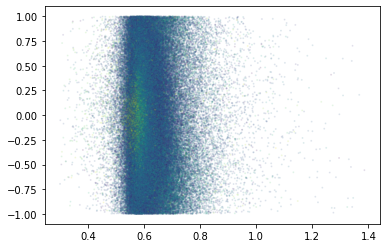

In [36]:
pl.scatter(finstars['sharpness'], finstars['roundness1'], s=1, c=finstars['peak'],
           norm=simple_norm(finstars['peak'], stretch='log', max_percent=99.95, min_percent=1),
           alpha=0.1)

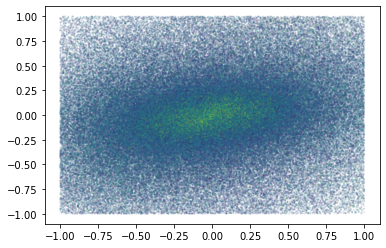

In [35]:
pl.scatter(finstars['roundness1'], finstars['roundness2'], s=1, c=finstars['peak'],
           norm=simple_norm(finstars['peak'], stretch='log', max_percent=99.95, min_percent=1),
           alpha=0.1)

In [26]:
from astropy.nddata import NDData
from astropy.visualization import simple_norm
import pylab as pl

In [38]:
daofind_tuned = DAOStarFinder(threshold=15 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=0.25, roundlo=-0.25,
                              sharplo=0.40, sharphi=0.8)
finstars = daofind_tuned(np.nan_to_num(data))
finstars

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2258.995991683679,14.169631122532792,0.6988292006043927,-0.05985653273397342,-0.02619458703343955,25,0.0,18.16801197729378,4.507357990227362,-1.634805131590824
2,2073.92026001634,16.215379620513694,0.6039849435698356,-0.004727840444658003,0.1375110313253946,25,0.0,18.766886411394392,2.8327891363551605,-1.130535620623677
3,2126.2049496716972,15.885238505321064,0.5701460034524879,0.07536251218172721,0.06884241108443992,25,0.0,47.77587850277241,13.699209733126482,-2.841738786788544
4,2179.5548889853744,15.819567984537402,0.5723747605674087,0.08725659840182305,-0.06607955342271772,25,0.0,58.49470033191499,17.612547542339932,-3.114555446073947
5,2024.1200552186863,17.25539821039623,0.5675522902543589,0.12128798288425985,-0.22585682186566652,25,0.0,27.560570231023824,1.7966418345037685,-0.6361537698422985
6,2244.035208817811,16.905585458160925,0.6185198256726266,0.203948162008981,0.04882592266134384,25,0.0,25.102423775870847,5.910215058142796,-1.9290082101834314
7,1846.9347414130534,20.499343063326847,0.6016177665339559,-0.03342589664234617,-0.014716864059944856,25,0.0,44.728504448293535,11.37429444478004,-2.639811166456459
8,1875.8622957580164,19.986068610016087,0.6093331888477673,0.0027979674783617427,-0.1786956725845606,25,0.0,30.780218941824778,5.606982551725475,-1.8718230115672925
9,1982.9917577584386,19.62604451994597,0.5735961621959619,0.02437546764696139,-0.0683616693884737,25,0.0,110.77083184584131,21.11733373574826,-3.311597708784472


Building EPSF


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

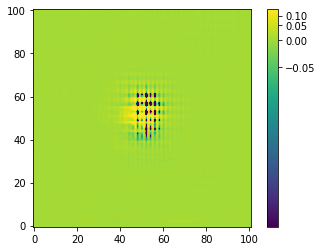

In [39]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

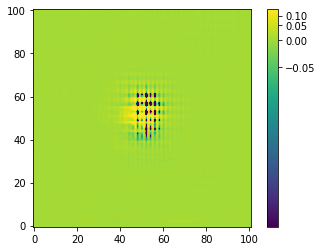

In [40]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()

In [ ]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

Building EPSF
nstars = 11773


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

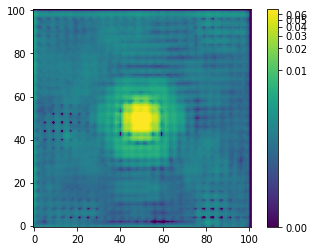

In [49]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

In [46]:
from photutils.psf import EPSFStars

Building EPSF


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

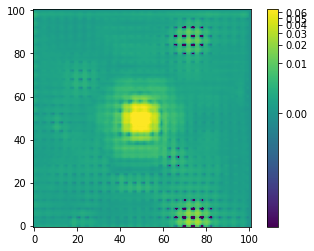

In [47]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

# reject stars with negative pixels
stars = EPSFStars([x for x in stars if x.data.min() >= 0])
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 18144


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

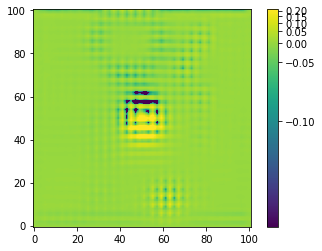

In [48]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 50], size=25)

# reject stars with negative pixels
stars = EPSFStars([x for x in stars if x.data.min() >= 0])
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11773


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

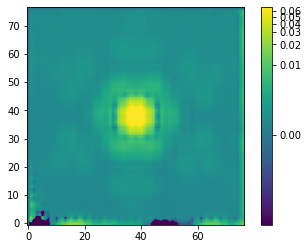

In [50]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=3, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

# Best combination

It looks like brighter stars, with peak >200, and oversampling=4 was good enough

Building EPSF
nstars = 8229


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

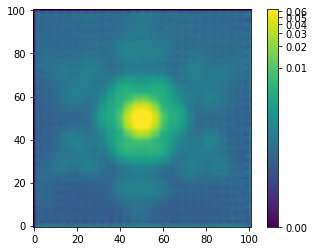

In [51]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

In [ ]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=3, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=35)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11773


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

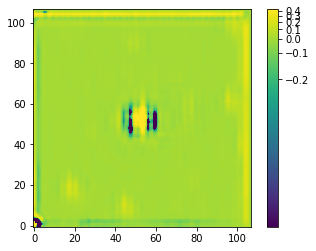

In [53]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()

Building EPSF
nstars = 8229


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

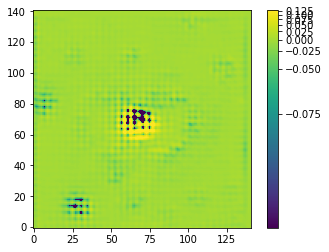

In [54]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=35)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')